In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns



spark = SparkSession.builder \
    .appName("Spotify Regression") \
    .config("spark.driver.memory", "15g") \
    .getOrCreate()

In [2]:
df = spark.read.parquet("data/df_clean_parquet")
df.printSchema()


root
 |-- spotify_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- daily_rank: float (nullable = true)
 |-- daily_movement: float (nullable = true)
 |-- weekly_movement: float (nullable = true)
 |-- country: string (nullable = true)
 |-- snapshot_date: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- is_explicit: string (nullable = true)
 |-- duration_ms: float (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- time

In [3]:
numeric_cols = [
    "daily_rank", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo"
]
label_col = "popularity"


In [4]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [5]:
print(f"Train dataset size: {train_df.count()}")
print(f"Test  dataset size: {test_df.count()}")

Train dataset size: 795388
Test  dataset size: 198883


In [6]:
def create_spotify_pipeline(numeric_features: list[str], label_col: str, max_iter: int) -> Pipeline:

    vector_assembler = VectorAssembler(inputCols=numeric_features, outputCol="num_features")
    

    scaler = MinMaxScaler(inputCol="num_features", outputCol="features")
    

    lr = LinearRegression(featuresCol="features", labelCol=label_col, predictionCol="prediction", 
                          maxIter=max_iter, standardization=False)
    
    pipeline = Pipeline(stages=[vector_assembler, scaler, lr])
    return pipeline

pipeline = create_spotify_pipeline(numeric_cols, label_col=label_col, max_iter=20)

In [7]:
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].regParam, [0.01, 0.1, 1.0]) \
    .addGrid(pipeline.getStages()[-1].elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

cv_evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")

cross_validator = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=cv_evaluator,
    numFolds=5
)

In [8]:
cv_model = cross_validator.fit(train_df)

def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    best_model = cv_model.bestModel
    return {
        "regParam": best_model.stages[-1].getRegParam(),
        "elasticNetParam": best_model.stages[-1].getElasticNetParam(),
        "maxIter": best_model.stages[-1].getMaxIter()
    }

print("Лучшие параметры модели:")
for key, value in get_best_model_params(cv_model).items():
    print(f"{key}: {value}")


Лучшие параметры модели:
regParam: 0.01
elasticNetParam: 0.5
maxIter: 20


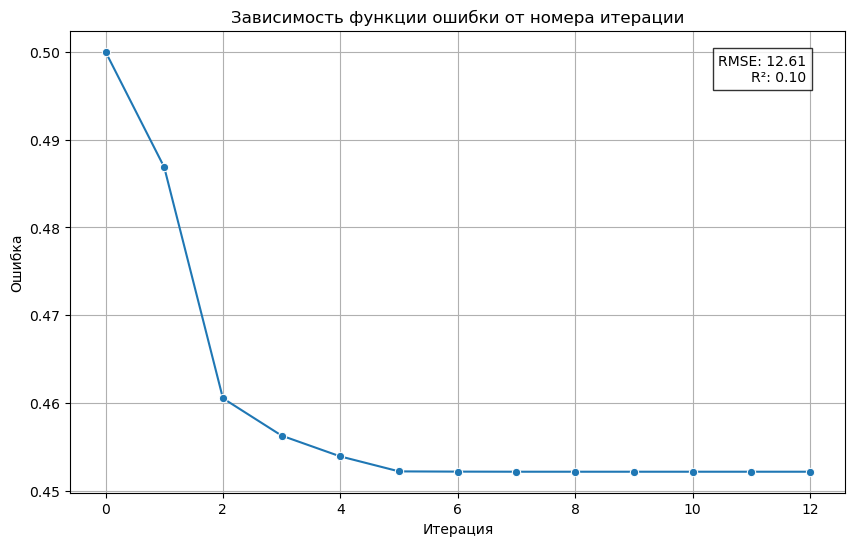

In [9]:
def plot_training_summary(cv_model: CrossValidatorModel) -> None:
    best_model = cv_model.bestModel
    training_summary = best_model.stages[-1].summary
    objective_history = training_summary.objectiveHistory
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(objective_history)), y=objective_history, marker='o')
    plt.xlabel("Итерация")
    plt.ylabel("Ошибка")
    plt.title("Зависимость функции ошибки от номера итерации")
    
    rmse = training_summary.rootMeanSquaredError
    r2 = training_summary.r2
    plt.text(0.95, 0.95, f"RMSE: {rmse:.2f}\nR²: {r2:.2f}",
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(facecolor='white', alpha=0.8), zorder=5)
    plt.grid()
    plt.show()

plot_training_summary(cv_model)



In [10]:

test_df_predictions = cv_model.transform(test_df)


predictions_pd = test_df_predictions.select("popularity", "prediction").limit(10).toPandas()


display(predictions_pd)


,popularity,prediction
0,87.0,76.799633
1,87.0,76.512263
2,87.0,76.368578
3,86.0,76.224893
4,87.0,76.224893
5,85.0,76.081207
6,86.0,75.937522
7,86.0,75.650152
8,87.0,74.356987
9,86.0,74.356987


In [11]:
def evaluate_model(data: DataFrame, metric_name: str) -> float:
    evaluator = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName=metric_name)
    return evaluator.evaluate(data)

test_rmse = evaluate_model(test_df_predictions, "rmse")
test_r2 = evaluate_model(test_df_predictions, "r2")

print(f"RMSE on test data: {test_rmse:.2f}")
print(f"R² on test data: {test_r2:.2f}")


RMSE on test data: 12.67
R² on test data: 0.10
